In [1]:
import sqlite3 as sql
import pandas as pd
import spacy
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import re
import tqdm
import tqdm as notebook_tqdm
from textblob import TextBlob
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jaysh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data Fetching

In [2]:
# Connection with the database
def connect_to_db(db_path):
    try:
        conn = sql.connect(db_path)
        return conn
    except Exception as e:
        print(f"Error connecting to database: {e}")
        return None

# Fetch the data from the database
def fetch_text_data(conn):
    if conn is None:
        return pd.DataFrame()  # Return an empty DataFrame if connection failed
    query = 'SELECT * from content,links WHERE content.id = links.id'
    df = pd.read_sql_query(query, conn)
    return df

# Use the absolute path to the database file
db_path = 'C:/Users/jaysh/Documents/TFG/Code/data/processed/articles.db'
conn = connect_to_db(db_path)
df = fetch_text_data(conn)

if not df.empty:
    print('Data fetched from the database.')
        # Drop the duplicate 'id' column (assuming the second one is redundant)
    df = df.loc[:, ~df.columns.duplicated()]

    # Convert 'publish_date' to datetime format
    df["publish_date"] = pd.to_datetime(df["publish_date"])

    # Check the cleaned DataFrame
    print(df.info())

else:
    print("No data fetched from the database.")

Data fetched from the database.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3832 entries, 0 to 3831
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              3832 non-null   int64         
 1   title           3832 non-null   object        
 2   publish_date    3832 non-null   datetime64[ns]
 3   text            3832 non-null   object        
 4   outlier         3832 non-null   int64         
 5   truncated_text  3832 non-null   object        
 6   tokens          3832 non-null   object        
 7   clean_text      3832 non-null   object        
 8   clean_title     3832 non-null   object        
 9   newspaper       3832 non-null   object        
 10  url             3832 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(8)
memory usage: 329.4+ KB
None


# LABELS

 ## ANALISIS DE SENTIMIENTO


In [3]:
from textblob import TextBlob

# Function to get sentiment score
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity  # -1 (negative) to +1 (positive)

df["sentiment_score"] = df["clean_text"].apply(get_sentiment)

# Define a function to classify sentiment
def classify_sentiment(score):
    if score > 0.2:
        return "POS"
    elif score < -0.2:
        return "NEG"
    else:
        return "NEU"

df["sentiment"] = df["sentiment_score"].apply(classify_sentiment)

# Print first 10 results
print(df[["clean_text", "sentiment_score", "sentiment"]].head(10))


                                          clean_text  sentiment_score  \
0  presidente joe biden terminando mandato todaví...         0.083333   
1  vida sucede línea recta veces enmaraña luchar ...        -0.052273   
2  saliendo chicos mayores después tiempo centro ...         0.009524   
3  mismo día lalachus mostró estampa vaquilla gra...        -0.100000   
4  primer disparo batalla donald trump ciudades s...         0.177451   
5  cámara representantes aprobó martes proyecto l...         0.112121   
6  rescate madre migrante hijo nacido travesía ru...         0.000000   
7  refugios organizaciones brindan atención migra...         0.066667   
8  papa francisco elegido cardenal robert mcelroy...         0.250000   
9  niños migrantes méxico cada vez comunes último...         0.266667   

  sentiment  
0       NEU  
1       NEU  
2       NEU  
3       NEU  
4       NEU  
5       NEU  
6       NEU  
7       NEU  
8       POS  
9       POS  


In [4]:
print(df["sentiment_score"].describe())

count    3832.000000
mean        0.039364
std         0.187481
min        -1.000000
25%         0.000000
50%         0.000000
75%         0.100000
max         0.900000
Name: sentiment_score, dtype: float64


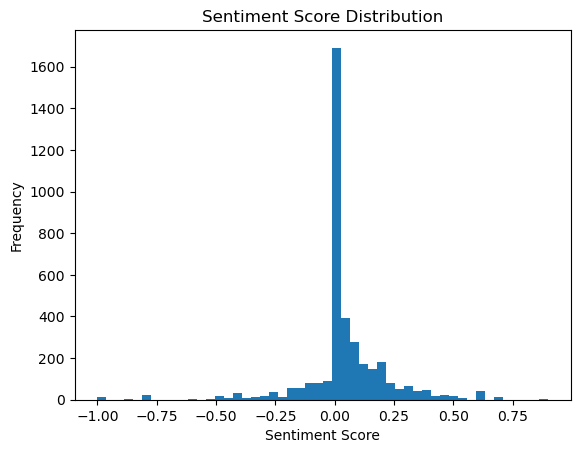

In [5]:
plot = df["sentiment_score"].plot(kind='hist', bins=50, title="Sentiment Score Distribution")
plot.set_xlabel("Sentiment Score")      
plot.set_ylabel("Frequency")
plt.show()

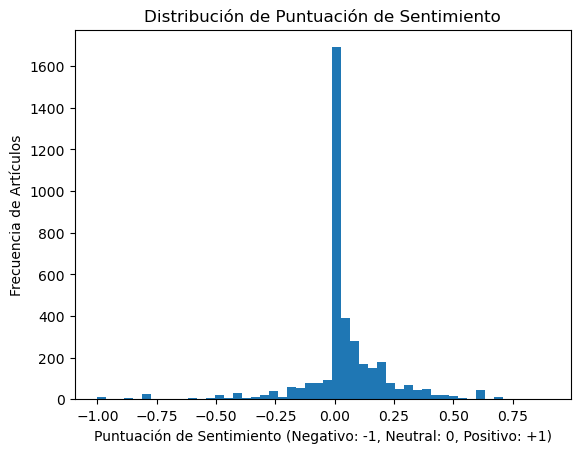

In [6]:
import matplotlib.pyplot as plt

# Plot histogram
plot = df["sentiment_score"].plot(kind='hist', bins=50, title="Distribución de Puntuación de Sentimiento")

# Improved axis labels with explanations
plot.set_xlabel("Puntuación de Sentimiento (Negativo: -1, Neutral: 0, Positivo: +1)")
plot.set_ylabel("Frecuencia de Artículos")

# Show plot
plt.show()


## LEXICON ANALYSIS

In [7]:
# Define Spanish Lexicons
pro_immigration_words = {
    "refugiado", "solidaridad", "humanitario", "derechos", "asilo",
    "acogida", "integración", "beneficio", "protección", "inclusión",
    "tolerancia", "convivencia", "hospitalidad", "multicultural", "diversidad",
    "ayuda", "bienestar", "cooperación", "derechos humanos", "seguridad social"
}


anti_immigration_words = {
    "crisis", "delito", "ilegal", "amenaza", "colapso",
    "avalancha", "extranjero", "criminal", "invasión", "delincuencia",
    "saturación", "problema migratorio", "descontrol", "violencia", "abusos",
    "peligro", "expulsión", "mafias", "irregular", "marea migratoria"
}

# Function to Count Lexicon Words
def lexicon_analysis(text):
    words = set(text.split())  # Convert text into a set of words
    pro_count = sum(word in pro_immigration_words for word in words)
    anti_count = sum(word in anti_immigration_words for word in words)
    
    return pro_count, anti_count

# Apply function to all articles
df["pro_immigration_count"], df["anti_immigration_count"] = zip(*df["clean_text"].apply(lexicon_analysis))

# Print first 10 results
print(df[["clean_text", "pro_immigration_count", "anti_immigration_count"]].head(10))


                                          clean_text  pro_immigration_count  \
0  presidente joe biden terminando mandato todaví...                      1   
1  vida sucede línea recta veces enmaraña luchar ...                      1   
2  saliendo chicos mayores después tiempo centro ...                      2   
3  mismo día lalachus mostró estampa vaquilla gra...                      0   
4  primer disparo batalla donald trump ciudades s...                      1   
5  cámara representantes aprobó martes proyecto l...                      0   
6  rescate madre migrante hijo nacido travesía ru...                      0   
7  refugios organizaciones brindan atención migra...                      3   
8  papa francisco elegido cardenal robert mcelroy...                      1   
9  niños migrantes méxico cada vez comunes último...                      1   

   anti_immigration_count  
0                       4  
1                       0  
2                       1  
3                 

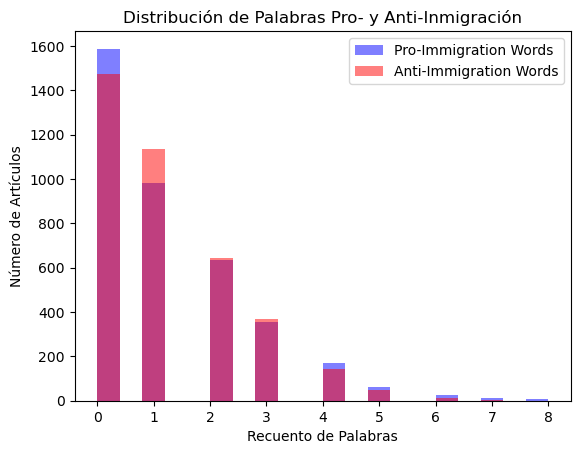

In [8]:
import matplotlib.pyplot as plt

# Plot Distribution of Pro- and Anti-Immigration Words
plt.hist(df["pro_immigration_count"], bins=20, alpha=0.5, label="Pro-Immigration Words", color="blue")
plt.hist(df["anti_immigration_count"], bins=20, alpha=0.5, label="Anti-Immigration Words", color="red")
plt.legend()
plt.xlabel("Recuento de Palabras")
plt.ylabel("Número de Artículos")
plt.title("Distribución de Palabras Pro- y Anti-Inmigración")
plt.show()


## ANALISIS DE POSTURA

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Convertir los sets a listas para usarlos en TF-IDF
pro_immigration_list = list(pro_immigration_words)
anti_immigration_list = list(anti_immigration_words)

# Combinar ambas listas
lexicon_words = pro_immigration_list + anti_immigration_list

# Crear el modelo TF-IDF usando sólo las palabras del léxico
vectorizer = TfidfVectorizer(vocabulary=lexicon_words)
tfidf_matrix = vectorizer.fit_transform(df["clean_text"])

# Convertir el TF-IDF en un DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Concatenar TF-IDF con el DataFrame original
df = pd.concat([df.reset_index(drop=True), tfidf_df.reset_index(drop=True)], axis=1)

# Sumar los puntajes TF-IDF para palabras Pro y Anti Inmigración
df["pro_immigration_tfidf"] = df[pro_immigration_list].sum(axis=1)
df["anti_immigration_tfidf"] = df[anti_immigration_list].sum(axis=1)

# Función para determinar la postura usando TF-IDF
def detect_stance_tfidf(pro_score, anti_score):
    if pro_score > anti_score:
        return "PRO"
    elif anti_score > pro_score:
        return "ANTI"
    else:
        return "NEU"

# Aplicar la función para clasificar la postura
df["stance_tfidf"] = df.apply(lambda row: detect_stance_tfidf(row["pro_immigration_tfidf"], row["anti_immigration_tfidf"]), axis=1)

# Mostrar resultados
print(df["stance_tfidf"].value_counts())
print(df[["clean_text", "pro_immigration_tfidf", "anti_immigration_tfidf", "stance_tfidf"]].head())


stance_tfidf
PRO     1525
ANTI    1460
NEU      847
Name: count, dtype: int64
                                          clean_text  pro_immigration_tfidf  \
0  presidente joe biden terminando mandato todaví...               1.198009   
1  vida sucede línea recta veces enmaraña luchar ...               2.000000   
2  saliendo chicos mayores después tiempo centro ...               2.358381   
3  mismo día lalachus mostró estampa vaquilla gra...               0.000000   
4  primer disparo batalla donald trump ciudades s...               0.417544   

   anti_immigration_tfidf stance_tfidf  
0                3.172619         ANTI  
1                0.000000          PRO  
2                0.810002          PRO  
3                0.000000          NEU  
4                3.198171         ANTI  


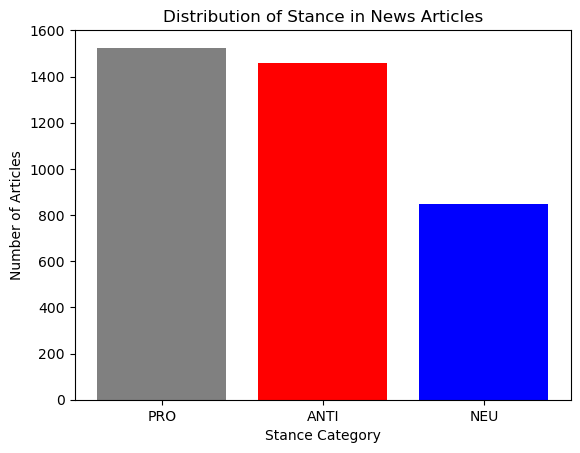

In [13]:
import matplotlib.pyplot as plt

# Count stance occurrences
stance_counts = df["stance_tfidf"].value_counts()

# Create a bar chart
plt.bar(stance_counts.index, stance_counts.values, color=["gray", "red", "blue"])
plt.xlabel("Stance Category")
plt.ylabel("Number of Articles")
plt.title("Distribution of Stance in News Articles")

# Show the plot
plt.show()


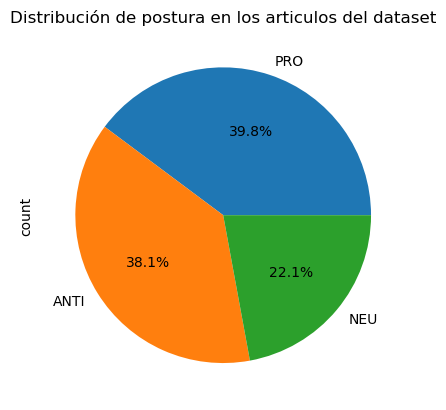

In [14]:
plot = df["stance_tfidf"].value_counts().plot(kind='pie', title="Distribución de postura en los articulos del dataset", autopct='%1.1f%%')
plt.show()

In [15]:
#Count stances per newspaper
stance_per_newspaper = df.groupby("newspaper")["stance_tfidf"].value_counts().unstack()

#Print results
print(stance_per_newspaper)


stance_tfidf   ANTI  NEU  PRO
newspaper                    
20_minutos       39   22   36
ABC             151  112  210
el_mundo        506  448  485
el_pais         454  121  522
la_vanguardia   310  144  272


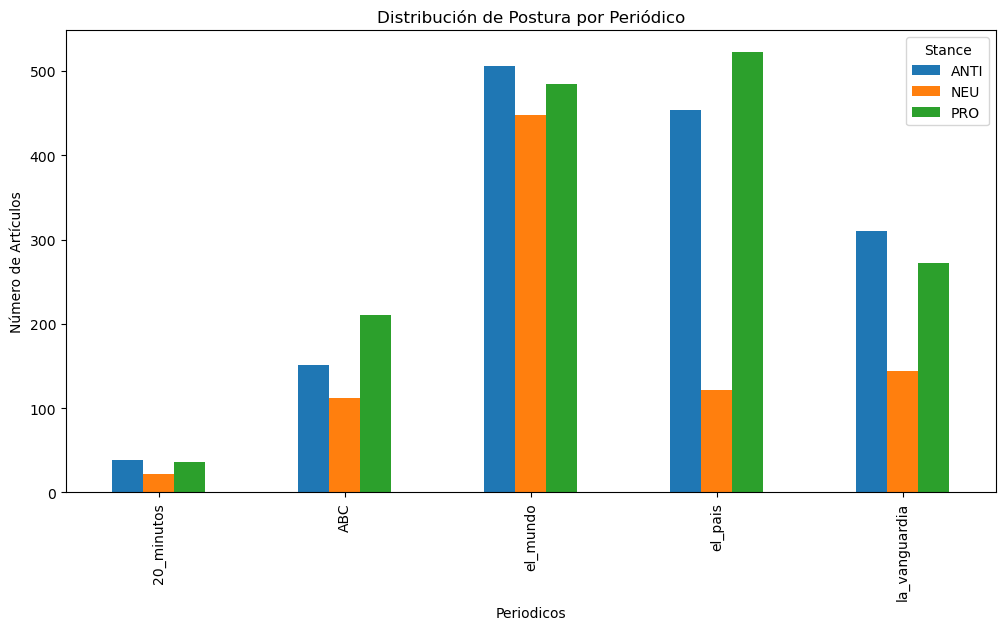

In [16]:
# Plot stance per newspaper
stance_per_newspaper.plot(kind="bar", figsize=(12,6), stacked=False)
plt.xlabel("Periodicos")
plt.ylabel("Número de Artículos")
plt.title("Distribución de Postura por Periódico")
plt.legend(title="Stance")
plt.show()


## N.E.R

In [17]:
# Function to Extract Named Entities
import spacy 
nlp = spacy.load("es_core_news_sm")
def extract_entities(text):
    doc = nlp(text)
    persons = [ent.text for ent in doc.ents if ent.label_ == "PER"]
    locations = [ent.text for ent in doc.ents if ent.label_ == "LOC"]
    organizations = [ent.text for ent in doc.ents if ent.label_ == "ORG"]
    
    return persons, locations, organizations

# Apply function to all articles
df["persons"], df["locations"], df["organizations"] = zip(*df["clean_text"].apply(extract_entities))

# Print first 10 results
print(df[["clean_text", "persons", "locations", "organizations"]].head(10))



                                          clean_text  \
0  presidente joe biden terminando mandato todaví...   
1  vida sucede línea recta veces enmaraña luchar ...   
2  saliendo chicos mayores después tiempo centro ...   
3  mismo día lalachus mostró estampa vaquilla gra...   
4  primer disparo batalla donald trump ciudades s...   
5  cámara representantes aprobó martes proyecto l...   
6  rescate madre migrante hijo nacido travesía ru...   
7  refugios organizaciones brindan atención migra...   
8  papa francisco elegido cardenal robert mcelroy...   
9  niños migrantes méxico cada vez comunes último...   

                                             persons  \
0  [presidente, joe biden, donald trump, salvador...   
1  [vivió empezó, brille, ponía profesión, brille...   
2  [hortaleza relato, oposición, gil portavoz, ad...   
3  [grand prix, mahmoud bakhum, mahmoud murió, je...   
4             [llegó, stephen miller, jim mcdonnell]   
5  [antonio ibarra recibió, john fetterman, mik

In [18]:
from collections import Counter

#  Count top 10 most mentioned entities
top_persons = Counter([person for sublist in df["persons"] for person in sublist]).most_common(10)
top_locations = Counter([loc for sublist in df["locations"] for loc in sublist]).most_common(10)
top_organizations = Counter([org for sublist in df["organizations"] for org in sublist]).most_common(10)

#  Print results
print(" Most Mentioned Persons:", top_persons)
print(" Most Mentioned Locations:", top_locations)
print(" Most Mentioned Organizations:", top_organizations)


 Most Mentioned Persons: [('pedro', 596), ('fernando', 305), ('llegó', 251), ('donald trump', 186), ('donald', 184), ('harris', 163), ('von der', 155), ('joe biden', 141), ('fernando grandemarlaska', 124), ('matteo salvini', 82)]
 Most Mentioned Locations: [('europa', 1461), ('italia', 769), ('madrid', 752), ('canarias', 747), ('alemania', 527), ('francia', 466), ('ceuta', 450), ('marruecos', 371), ('barcelona', 363), ('eeuu', 357)]
 Most Mentioned Organizations: [('pp', 1507), ('ue', 969), ('psoe', 768), ('onu', 126), ('ningún', 108), ('otan', 81), ('psc', 79), ('oim', 70), ('pnv', 66), ('vox', 58)]


In [19]:
# Function to Extract Named Entities
import spacy 
nlp = spacy.load("es_core_news_sm")
def extract_entities(text):
    doc = nlp(text)
    persons = [ent.text for ent in doc.ents if ent.label_ == "PER"]
    locations = [ent.text for ent in doc.ents if ent.label_ == "LOC"]
    organizations = [ent.text for ent in doc.ents if ent.label_ == "ORG"]
    
    return persons, locations, organizations

# Apply function to all articles
df["persons_2"], df["locations_2"], df["organizations_2"] = zip(*df["text"].apply(extract_entities))

# Print first 10 results
print(df[["clean_text", "persons_2", "locations_2", "organizations_2"]].head(10))

                                          clean_text  \
0  presidente joe biden terminando mandato todaví...   
1  vida sucede línea recta veces enmaraña luchar ...   
2  saliendo chicos mayores después tiempo centro ...   
3  mismo día lalachus mostró estampa vaquilla gra...   
4  primer disparo batalla donald trump ciudades s...   
5  cámara representantes aprobó martes proyecto l...   
6  rescate madre migrante hijo nacido travesía ru...   
7  refugios organizaciones brindan atención migra...   
8  papa francisco elegido cardenal robert mcelroy...   
9  niños migrantes méxico cada vez comunes último...   

                                           persons_2  \
0  [Joe Biden, Donald Trump, Nicolás Maduro, Madu...   
1  [Más, Paloma Sánchez-Garnica, vivió, Empezó De...   
2  [Lorena Morales, según, Elena Gil, Presupuesto...   
3  [Lalachus, Jesús, Mahmoud Bakhum, Mahmoud, Jes...   
4  [Donald Trump, llegó, Stephen Miller, Miller, ...   
5  [Donald Trump, Además, Laken Riley, Pennsylv

In [20]:
from collections import Counter

#  Count top 10 most mentioned entities
top_persons = Counter([person for sublist in df["persons_2"] for person in sublist]).most_common(10)
top_locations = Counter([loc for sublist in df["locations_2"] for loc in sublist]).most_common(10)
top_organizations = Counter([org for sublist in df["organizations_2"] for org in sublist]).most_common(10)

#  Print results
print(" Most Mentioned Persons:", top_persons)
print(" Most Mentioned Locations:", top_locations)
print(" Most Mentioned Organizations:", top_organizations)

 Most Mentioned Persons: [('España', 1383), ('Trump', 1352), ('Según', 802), ('Pedro Sánchez', 692), ('También', 648), ('Además', 611), ('Junts', 597), ('Así', 580), ('Donald Trump', 576), ('Salvamento Marítimo', 468)]
 Most Mentioned Locations: [('Gobierno', 2133), ('Canarias', 1941), ('España', 1811), ('Europa', 1420), ('Ceuta', 1033), ('Estados Unidos', 989), ('Marruecos', 957), ('Italia', 851), ('Madrid', 838), ('Estado', 815)]
 Most Mentioned Organizations: [('PP', 2435), ('Vox', 1542), ('UE', 1044), ('PSOE', 910), ('Guardia Civil', 615), ('Congreso', 590), ('Unión Europea', 539), ('Cruz Roja', 314), ('ERC', 258), ('Comisión Europea', 249)]


### COMPARISON BETWEEN DIFFERENT N.E.R ANALYSIS

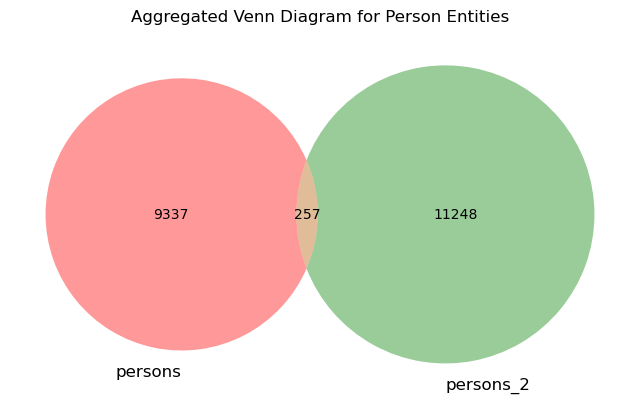

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# Aggregate all entities from each column (union over all rows)
set_persons = set().union(*df['persons'])
set_persons_2 = set().union(*df['persons_2'])

# Create a Venn diagram
plt.figure(figsize=(8,8))
venn2([set_persons, set_persons_2],
      set_labels=('persons', 'persons_2'))
plt.title("Aggregated Venn Diagram for Person Entities")
plt.show()

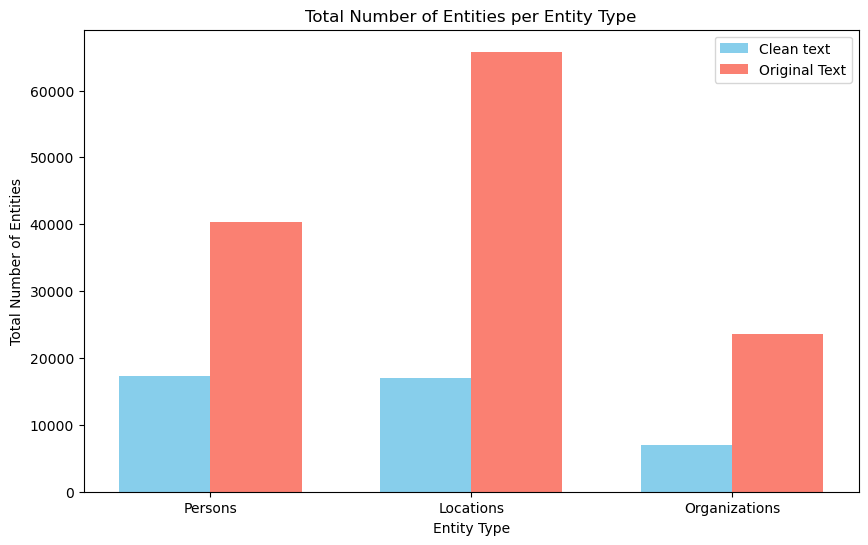

In [22]:
import numpy as np

# Count the total number of entities in each column by summing lengths of lists
persons_total = df['persons'].apply(len).sum()
persons_2_total = df['persons_2'].apply(len).sum()
locations_total = df['locations'].apply(len).sum()
locations_2_total = df['locations_2'].apply(len).sum()
organizations_total = df['organizations'].apply(len).sum()
organizations_2_total = df['organizations_2'].apply(len).sum()

# Group the counts by entity type
# For Persons, Locations, and Organizations, each with two methods
group_names = ['Persons', 'Locations', 'Organizations']
method1_counts = [persons_total, locations_total, organizations_total]
method2_counts = [persons_2_total, locations_2_total, organizations_2_total]

# Create positions for grouped bars
x = np.arange(len(group_names))  # positions for groups
width = 0.35  # width of each bar

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Bar for first method (e.g. original)
bars1 = ax.bar(x - width/2, method1_counts, width, label='Clean text', color='skyblue')
# Bar for second method (e.g. alternative variant)
bars2 = ax.bar(x + width/2, method2_counts, width, label='Original Text', color='salmon')

# Labels and title
ax.set_xlabel('Entity Type')
ax.set_ylabel('Total Number of Entities')
ax.set_title('Total Number of Entities per Entity Type')
ax.set_xticks(x)
ax.set_xticklabels(group_names)
ax.legend()


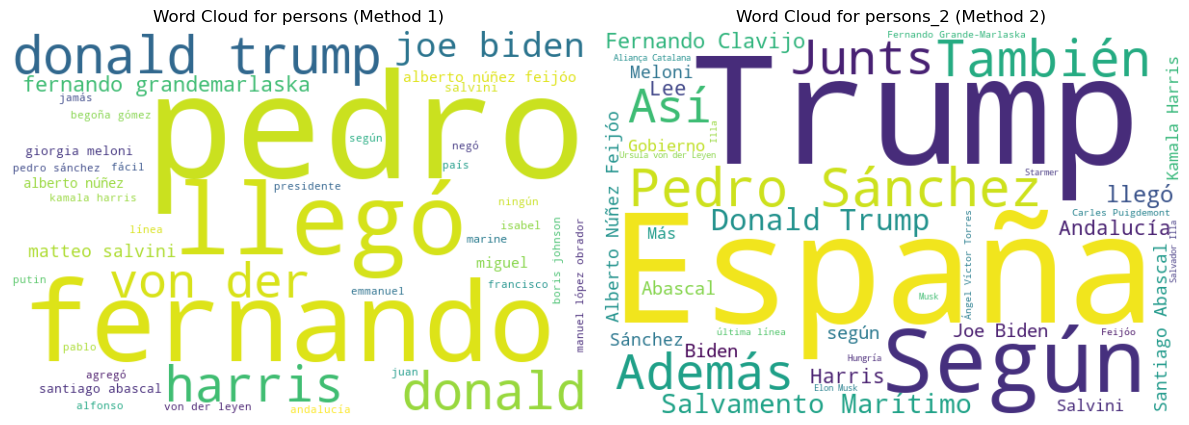

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud

# Flatten the lists of entities for each method (for example, persons)
persons_method1 = [entity for sublist in df['persons'] for entity in sublist]
persons_method2 = [entity for sublist in df['persons_2'] for entity in sublist]

# Count frequency of each entity
counter1 = Counter(persons_method1)
counter2 = Counter(persons_method2)

# Get top 10 most common entities (if there are less than 10, it will take all)
top10_method1 = dict(counter1.most_common(40))
top10_method2 = dict(counter2.most_common(40))

# Generate word clouds from these frequencies
wc1 = WordCloud(width=600, height=400, background_color='white').generate_from_frequencies(top10_method1)
wc2 = WordCloud(width=600, height=400, background_color='white').generate_from_frequencies(top10_method2)

# Plot side-by-side word clouds for visual comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(wc1, interpolation='bilinear')
axes[0].set_title('Word Cloud for persons (Method 1)')
axes[0].axis('off')

axes[1].imshow(wc2, interpolation='bilinear')
axes[1].set_title('Word Cloud for persons_2 (Method 2)')
axes[1].axis('off')

plt.tight_layout()
plt.show()

## WORD EMBEDDINGS

In [29]:
from gensim.models import Word2Vec

# Tokenize articles into words
df["tokens"] = df["clean_text"].apply(lambda x: x.split())

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=df["tokens"], vector_size=100, window=5, min_count=5, workers=4)

# Save the model for later use
word2vec_model.save("word2vec_news.model")

print("✅ Word2Vec Model Trained and Saved!")
# 

✅ Word2Vec Model Trained and Saved!


In [30]:
import numpy as np

# Function to Convert Articles into Word2Vec Vectors
def get_article_vector(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)  # Average the word vectors
    else:
        return np.zeros(model.vector_size)  # If no words match, return a zero vector

# Apply the function to all articles
df["vector"] = df["tokens"].apply(lambda tokens: get_article_vector(tokens, word2vec_model))

print("✅ Word2Vec Embeddings Ready!")


✅ Word2Vec Embeddings Ready!


In [31]:
# Load the trained Word2Vec model
word2vec_model = Word2Vec.load("word2vec_news.model")

# Find words similar to 'inmigrante'
print("Words similar to 'inmigrante':", word2vec_model.wv.most_similar("inmigrante"))

# Find words similar to 'crisis'
print("Words similar to 'crisis':", word2vec_model.wv.most_similar("crisis"))
# 

Words similar to 'inmigrante': [('migrante', 0.8132420182228088), ('residente', 0.7907806038856506), ('extranjero', 0.7898756265640259), ('cónyuge', 0.7814923524856567), ('pobre', 0.7778348326683044), ('foráneo', 0.7717391848564148), ('puta', 0.7682200074195862), ('generación', 0.7555934190750122), ('negra', 0.7525641322135925), ('buscarse', 0.7515230178833008)]
Words similar to 'crisis': [('presión', 0.9026204347610474), ('oleada', 0.7652792930603027), ('precedentes', 0.7611005902290344), ('sufre', 0.7490082383155823), ('política', 0.7383688688278198), ('covid', 0.7286363840103149), ('pandemia', 0.6909536719322205), ('tensión', 0.6815887689590454), ('vive', 0.680076003074646), ('atraviesa', 0.66890949010849)]


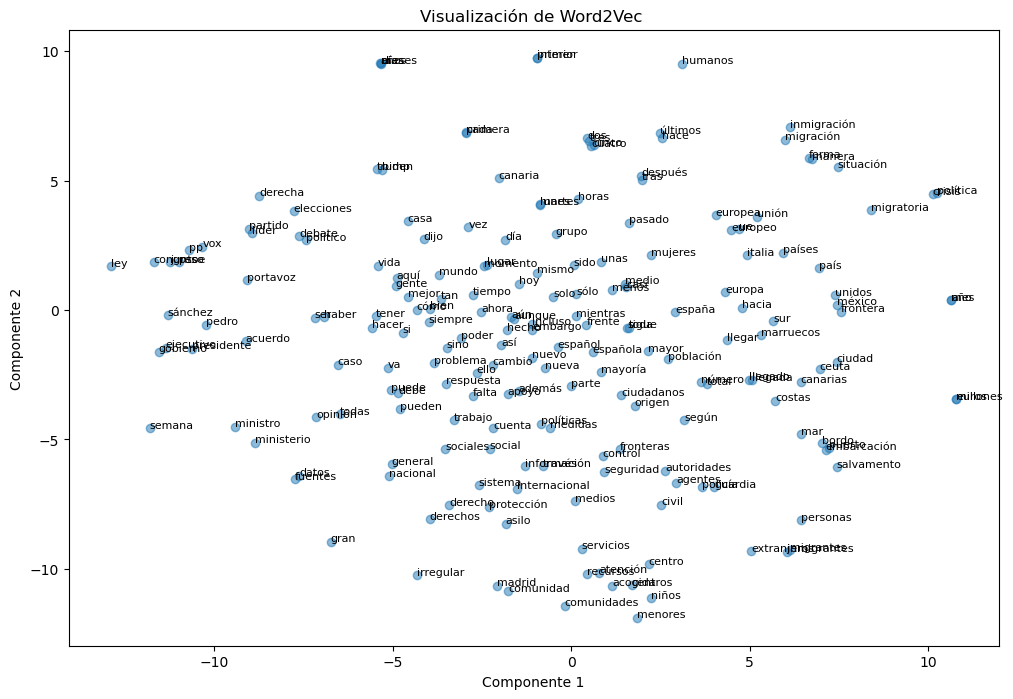

In [32]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Get the vocabulary words
words = list(word2vec_model.wv.index_to_key)[:200]  # Limit to 200 words for clarity
word_vectors = np.array([word2vec_model.wv[word] for word in words])

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
word_vectors_2d = tsne.fit_transform(word_vectors)

# Plot the words in 2D space
plt.figure(figsize=(12, 8))
plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1], alpha=0.5)

# Annotate words
for i, word in enumerate(words):
    plt.annotate(word, xy=(word_vectors_2d[i, 0], word_vectors_2d[i, 1]), fontsize=8)

plt.title("Visualización de Word2Vec ")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.show()


# CLUSTERING


NORMALIZATION OF THE DATA

In [34]:
print(df.columns.tolist())

['id', 'title', 'publish_date', 'text', 'outlier', 'truncated_text', 'tokens', 'clean_text', 'clean_title', 'newspaper', 'url', 'sentiment_score', 'sentiment', 'pro_immigration_count', 'anti_immigration_count', 'diversidad', 'acogida', 'tolerancia', 'protección', 'bienestar', 'refugiado', 'derechos', 'hospitalidad', 'multicultural', 'convivencia', 'ayuda', 'derechos humanos', 'solidaridad', 'inclusión', 'cooperación', 'asilo', 'humanitario', 'seguridad social', 'integración', 'beneficio', 'saturación', 'descontrol', 'criminal', 'violencia', 'invasión', 'extranjero', 'crisis', 'ilegal', 'expulsión', 'problema migratorio', 'peligro', 'delincuencia', 'abusos', 'colapso', 'mafias', 'avalancha', 'marea migratoria', 'delito', 'amenaza', 'irregular', 'pro_immigration_tfidf', 'anti_immigration_tfidf', 'stance_tfidf', 'diversidad', 'acogida', 'tolerancia', 'protección', 'bienestar', 'refugiado', 'derechos', 'hospitalidad', 'multicultural', 'convivencia', 'ayuda', 'derechos humanos', 'solidarida

In [35]:
# Step 1: Remove Duplicates
df = df.loc[:, ~df.columns.duplicated()]

# Step 2: Check for columns that are problematic
lexicon_columns = list(pro_immigration_words) + list(anti_immigration_words)
columns_to_remove = [col for col in df.columns if col in lexicon_columns and 'tfidf' not in col]

# Step 3: Drop these unnecessary columns
df.drop(columns=columns_to_remove, inplace=True)

# Step 4: Display remaining columns
print("Columns after cleaning:\n", df.columns)


Columns after cleaning:
 Index(['id', 'title', 'publish_date', 'text', 'outlier', 'truncated_text',
       'tokens', 'clean_text', 'clean_title', 'newspaper', 'url',
       'sentiment_score', 'sentiment', 'pro_immigration_count',
       'anti_immigration_count', 'pro_immigration_tfidf',
       'anti_immigration_tfidf', 'stance_tfidf', 'persons', 'locations',
       'organizations', 'persons_2', 'locations_2', 'organizations_2',
       'vector'],
      dtype='object')


In [36]:
df.head(1)

,id,title,publish_date,text,outlier,truncated_text,tokens,clean_text,clean_title,newspaper,...,pro_immigration_tfidf,anti_immigration_tfidf,stance_tfidf,persons,locations,organizations,persons_2,locations_2,organizations_2,vector
0,1,Biden extiende por 18 meses el estatus de prot...,2025-01-10,El presidente Joe Biden está terminando su man...,0,[CLS] El presidente Joe Biden está terminando ...,"[presidente, joe, biden, terminando, mandato, ...",presidente joe biden terminando mandato todaví...,biden extiende meses estatus protección tempor...,el_pais,...,1.198009,3.172619,ANTI,"[presidente, joe biden, donald trump, salvador...",[nueva york],[],"[Joe Biden, Donald Trump, Nicolás Maduro, Madu...","[Caracas, en Estados Unidos, Estados Unidos, E...","[DHS, TPS, DHS, TPS, TPS, DHS, TPS, TPS, DHS, ...","[0.22440377, 0.6875314, 0.06695703, -0.2413616..."


In [38]:
import numpy as np
from gensim.models import Word2Vec

# Load your Word2Vec model (replace with your own model path)
w2v_model = Word2Vec.load("word2vec_news.model")

# Function to average Word2Vec vectors
def get_average_vector(words, model):
    vectors = [model.wv[word] for word in words if word in model.wv]
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)  # Return a zero vector if no valid words are found

# Helper function to process each column safely
def process_ner_column(column):
    if column in df.columns:
        df[column] = df[column].apply(lambda x: x if isinstance(x, str) else "")
        df[column] = df[column].apply(lambda x: x.split(",") if x else [])
        df[f'{column}_vec'] = df[column].apply(lambda x: get_average_vector(x, w2v_model))

# Process each NER column
process_ner_column('persons')
process_ner_column('locations')
process_ner_column('organizations')


Prepare data for clustering

In [39]:
additional_features = [
    'sentiment_score',               # Sentiment analysis score
    'pro_immigration_tfidf',          # TF-IDF score for Pro-Immigration words
    'anti_immigration_tfidf',         # TF-IDF score for Anti-Immigration words
    'persons_vec',                    # Word2Vec embedding for persons
    'locations_vec',                  # Word2Vec embedding for locations
    'organizations_vec'               # Word2Vec embedding for organizations
]


In [41]:
import pandas as pd

# Function to flatten vector columns
def flatten_vectors(df, column_name):
    if column_name in df.columns:
        vectors = pd.DataFrame(df[column_name].tolist(), index=df.index)
        vectors.columns = [f"{column_name}_{i}" for i in range(vectors.shape[1])]
        return vectors
    return pd.DataFrame()

# Flatten the vector columns and add them to the original DataFrame
persons_vec_flat = flatten_vectors(df, 'persons_vec')
locations_vec_flat = flatten_vectors(df, 'locations_vec')
organizations_vec_flat = flatten_vectors(df, 'organizations_vec')

# Combine the flattened vectors with the original DataFrame
df_flattened = pd.concat([df, persons_vec_flat, locations_vec_flat, organizations_vec_flat], axis=1)


In [42]:
# Select the flattened columns by name
flattened_columns = list(persons_vec_flat.columns) + list(locations_vec_flat.columns) + list(organizations_vec_flat.columns)

# Define the new additional features
additional_features = [
    'sentiment_score', 
    'pro_immigration_tfidf', 
    'anti_immigration_tfidf'
] + flattened_columns


In [43]:
from sklearn.preprocessing import MinMaxScaler

# Select the columns to scale
df_additional = df_flattened[additional_features]

# Normalize the additional features
scaler = MinMaxScaler()
df_additional_scaled = scaler.fit_transform(df_additional)

# Prepare the final combined data with embeddings
X_embeddings = np.vstack(df['vector'].values)
X_combined = np.hstack([X_embeddings, df_additional_scaled])


KMEANS ONLY EMBEDDINGS

In [44]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Apply K-Means with Embeddings only
kmeans_embeddings = KMeans(n_clusters=3, random_state=42)
kmeans_embeddings.fit(X_embeddings)

# Save labels and evaluate
df['kmeans_labels_embeddings'] = kmeans_embeddings.labels_
silhouette_embeddings = silhouette_score(X_embeddings, kmeans_embeddings.labels_)
inertia_embeddings = kmeans_embeddings.inertia_

print(f"K-Means (Only Embeddings) - Silhouette Score: {silhouette_embeddings}")
print(f"K-Means (Only Embeddings) - Inertia: {inertia_embeddings}")


K-Means (Only Embeddings) - Silhouette Score: 0.2310876101255417
K-Means (Only Embeddings) - Inertia: 6601.8115234375


In [45]:
# Apply K-Means with Combined Features
kmeans_combined = KMeans(n_clusters=3, random_state=42)
kmeans_combined.fit(X_combined)

# Save labels and evaluate
df['kmeans_labels_combined'] = kmeans_combined.labels_
silhouette_combined = silhouette_score(X_combined, kmeans_combined.labels_)
inertia_combined = kmeans_combined.inertia_

print(f"K-Means (Combined Features) - Silhouette Score: {silhouette_combined}")
print(f"K-Means (Combined Features) - Inertia: {inertia_combined}")


K-Means (Combined Features) - Silhouette Score: 0.21926340708509476
K-Means (Combined Features) - Inertia: 7064.84137365749


KMEANS FEATURES NO NER

In [47]:
additional_features_2 = [
    'sentiment_score', 'pro_immigration_tfidf', 'anti_immigration_tfidf'
]


In [48]:
from sklearn.preprocessing import MinMaxScaler

# Normalize embeddings before combining them with other features
X_embeddings_scaled = MinMaxScaler().fit_transform(X_embeddings)
df_additional_scaled = MinMaxScaler().fit_transform(df_additional)

# Combine the scaled embeddings and additional features
X_combined_scaled = np.hstack([X_embeddings_scaled, df_additional_scaled])


In [49]:
# Apply K-Means with Combined Features
kmeans_combined = KMeans(n_clusters=3, random_state=42)
kmeans_combined.fit(X_combined_scaled)

# Save labels and evaluate
df['kmeans_labels_combined'] = kmeans_combined.labels_
silhouette_combined = silhouette_score(X_combined_scaled, kmeans_combined.labels_)
inertia_combined = kmeans_combined.inertia_

print(f"K-Means (Combined Features) - Silhouette Score: {silhouette_combined}")
print(f"K-Means (Combined Features) - Inertia: {inertia_combined}")

K-Means (Combined Features) - Silhouette Score: 0.19859387843021692
K-Means (Combined Features) - Inertia: 4432.050154617612


Multiple Tests 

In [50]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Normalize embeddings before combining them with other features
X_embeddings_scaled = MinMaxScaler().fit_transform(X_embeddings)

# Normalize the additional features
df_additional_scaled = MinMaxScaler().fit_transform(df_additional)

# Combine the scaled embeddings and additional features
X_combined_scaled = np.hstack([X_embeddings_scaled, df_additional_scaled])


In [51]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def test_kmeans(X, n_clusters_list, description):
    results = []
    
    for n_clusters in n_clusters_list:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        kmeans.fit(X)
        
        labels = kmeans.labels_
        silhouette = silhouette_score(X, labels)
        inertia = kmeans.inertia_
        
        results.append({
            "Description": description,
            "n_clusters": n_clusters,
            "Silhouette Score": silhouette,
            "Inertia": inertia
        })
        
        print(f"{description} | n_clusters: {n_clusters} | Silhouette Score: {silhouette:.4f} | Inertia: {inertia:.2f}")
        
    return results


In [53]:
# Define the range of clusters to test
n_clusters_list = [2,3, 4, 5, 6, 7]

# Test 1: Only Embeddings
results_only_embeddings = test_kmeans(X_embeddings_scaled, n_clusters_list, "Only Embeddings")

# Test 2: Embeddings + Additional Features (No NER)
results_no_ner = test_kmeans(X_combined_scaled, n_clusters_list, "Embeddings + No NER")

# Test 3: Embeddings + Persons Vec Only
X_persons = np.hstack([X_embeddings_scaled, df_flattened[persons_vec_flat.columns]])
results_persons_vec = test_kmeans(X_persons, n_clusters_list, "Embeddings + Persons Vec Only")

# Test 4: Embeddings + Locations Vec Only
X_locations = np.hstack([X_embeddings_scaled, df_flattened[locations_vec_flat.columns]])
results_locations_vec = test_kmeans(X_locations, n_clusters_list, "Embeddings + Locations Vec Only")

# Test 5: Embeddings + Organizations Vec Only
X_organizations = np.hstack([X_embeddings_scaled, df_flattened[organizations_vec_flat.columns]])
results_organizations_vec = test_kmeans(X_organizations, n_clusters_list, "Embeddings + Organizations Vec Only")

# Test 6: All Features Combined (Including NER embeddings)
X_all_combined = np.hstack([X_embeddings_scaled, df_additional_scaled])
results_all_combined = test_kmeans(X_all_combined, n_clusters_list, "All Features Combined")


Only Embeddings | n_clusters: 2 | Silhouette Score: 0.3335 | Inertia: 4722.18
Only Embeddings | n_clusters: 3 | Silhouette Score: 0.2148 | Inertia: 3970.23
Only Embeddings | n_clusters: 4 | Silhouette Score: 0.1974 | Inertia: 3543.81
Only Embeddings | n_clusters: 5 | Silhouette Score: 0.1753 | Inertia: 3277.09
Only Embeddings | n_clusters: 6 | Silhouette Score: 0.1803 | Inertia: 3063.33
Only Embeddings | n_clusters: 7 | Silhouette Score: 0.1808 | Inertia: 2940.56
Embeddings + No NER | n_clusters: 2 | Silhouette Score: 0.3172 | Inertia: 5189.43
Embeddings + No NER | n_clusters: 3 | Silhouette Score: 0.1986 | Inertia: 4432.05
Embeddings + No NER | n_clusters: 4 | Silhouette Score: 0.1794 | Inertia: 4000.99
Embeddings + No NER | n_clusters: 5 | Silhouette Score: 0.1599 | Inertia: 3727.87
Embeddings + No NER | n_clusters: 6 | Silhouette Score: 0.1438 | Inertia: 3581.33
Embeddings + No NER | n_clusters: 7 | Silhouette Score: 0.1490 | Inertia: 3362.85
Embeddings + Persons Vec Only | n_cluste

In [54]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reduce dimensionality of embeddings to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_embeddings_scaled)

# Add the PCA components to the DataFrame
df['PCA_1'] = X_pca[:, 0]
df['PCA_2'] = X_pca[:, 1]


In [55]:
def plot_clusters(df, label_column, title):
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(df['PCA_1'], df['PCA_2'], c=df[label_column], cmap='viridis', s=10)
    plt.colorbar(scatter, label='Cluster Label')
    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.show()


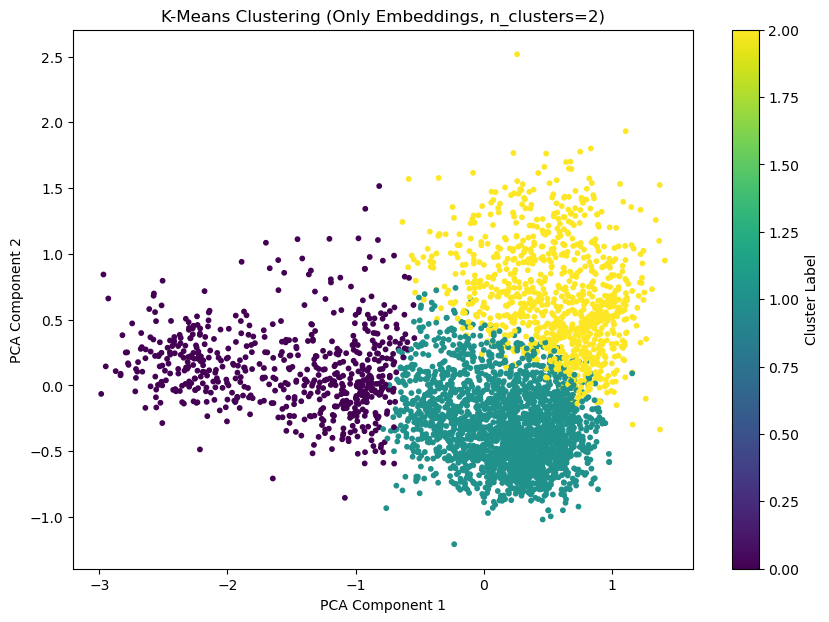

In [56]:
# Plot the clusters
plot_clusters(df, 'kmeans_labels_embeddings', 'K-Means Clustering (Only Embeddings, n_clusters=2)')


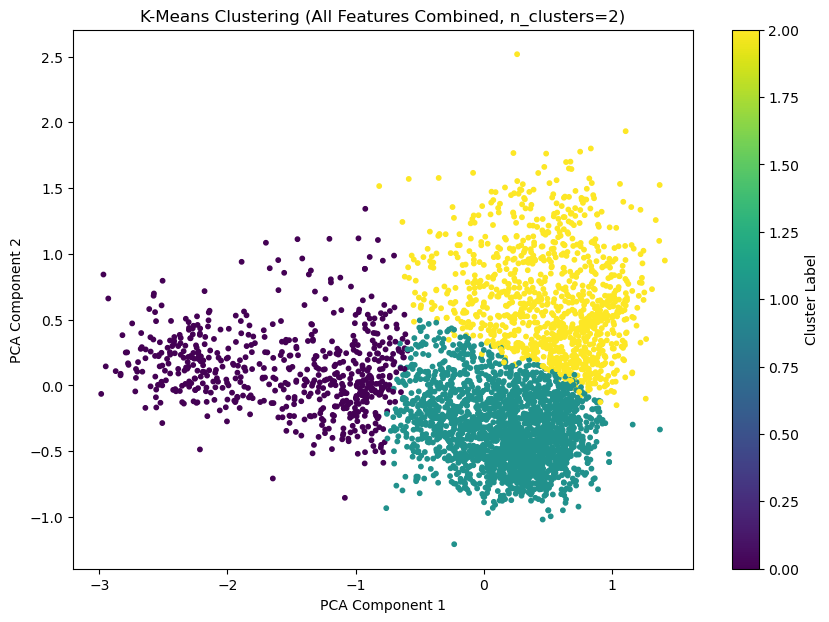

In [57]:
# Plot the clustering with all features combined (if you saved the labels)
plot_clusters(df, 'kmeans_labels_combined', 'K-Means Clustering (All Features Combined, n_clusters=2)')


In [59]:
# Make sure you are only using embeddings for this test
from sklearn.cluster import KMeans

kmeans_embeddings_2 = KMeans(n_clusters=2, random_state=42)
kmeans_embeddings_2.fit(X_embeddings_scaled)

# Save the labels in the DataFrame
df['kmeans_labels_embeddings'] = kmeans_embeddings_2.labels_

# Check label distribution
print(df['kmeans_labels_embeddings'].value_counts())


kmeans_labels_embeddings
1    3168
0     664
Name: count, dtype: int64


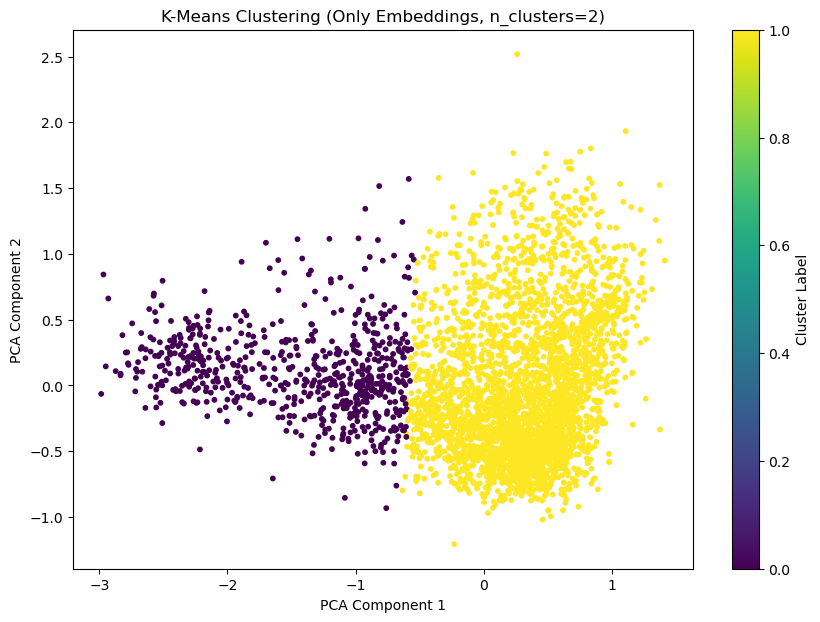

In [60]:
plot_clusters(df, 'kmeans_labels_embeddings', 'K-Means Clustering (Only Embeddings, n_clusters=2)')


# DBSCAN

In [62]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

def run_dbscan_tests(df, X_embeddings_scaled, X_combined_scaled, df_flattened, persons_vec_flat, locations_vec_flat, organizations_vec_flat):
    results = []
    
    def test_dbscan(X, eps, min_samples, description):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X)
        
        # Count number of outliers
        num_outliers = list(labels).count(-1)
        
        # Filter labels to calculate silhouette score (ignoring outliers)
        valid_labels = labels[labels != -1]
        if len(valid_labels) > 1:
            silhouette = silhouette_score(X[labels != -1], valid_labels)
        else:
            silhouette = None
        
        # Save labels in DataFrame
        df[f'dbscan_labels_{description}'] = labels
        
        # Store results
        results.append({
            "Setup": description,
            "eps": eps,
            "min_samples": min_samples,
            "Silhouette Score": silhouette,
            "Number of Outliers": num_outliers
        })
    
    # Define DBSCAN parameters
    eps = 0.5
    min_samples = 5
    
    # A. Only Embeddings
    test_dbscan(X_embeddings_scaled, eps, min_samples, "embeddings")
    
    # B. Embeddings + No NER
    test_dbscan(X_combined_scaled, eps, min_samples, "no_ner")
    
    # C. Embeddings + Persons Vec Only
    X_persons = np.hstack([X_embeddings_scaled, df_flattened[persons_vec_flat.columns]])
    test_dbscan(X_persons, eps, min_samples, "persons")
    
    # D. Embeddings + Locations Vec Only
    X_locations = np.hstack([X_embeddings_scaled, df_flattened[locations_vec_flat.columns]])
    test_dbscan(X_locations, eps, min_samples, "locations")
    
    # E. Embeddings + Organizations Vec Only
    X_organizations = np.hstack([X_embeddings_scaled, df_flattened[organizations_vec_flat.columns]])
    test_dbscan(X_organizations, eps, min_samples, "organizations")
    
    # F. All Features Combined
    X_all_combined = np.hstack([X_embeddings_scaled, X_combined_scaled])
    test_dbscan(X_all_combined, eps, min_samples, "all_features")
    
    # Convert results to a DataFrame for easy analysis
    results_df = pd.DataFrame(results)
    
    return results_df


In [63]:
results_df = run_dbscan_tests(df, X_embeddings_scaled, X_combined_scaled, df_flattened, persons_vec_flat, locations_vec_flat, organizations_vec_flat)
print(results_df)


           Setup  eps  min_samples  Silhouette Score  Number of Outliers
0     embeddings  0.5            5         -0.140050                1965
1         no_ner  0.5            5          0.037762                3069
2        persons  0.5            5         -0.140050                1965
3      locations  0.5            5         -0.140050                1965
4  organizations  0.5            5         -0.140050                1965
5   all_features  0.5            5          0.380130                3809


In [64]:
def plot_dbscan_clusters(df, label_column, title):
    plt.figure(figsize=(10, 7))
    
    # Extract labels
    labels = df[label_column]
    
    # Define colors for clusters and outliers
    unique_labels = set(labels)
    colors = [plt.cm.viridis(each) for each in np.linspace(0, 1, len(unique_labels))]
    
    for label, color in zip(unique_labels, colors):
        if label == -1:
            # Outliers are plotted as black
            color = [0, 0, 0, 1]
            label_name = "Outliers"
        else:
            label_name = f"Cluster {label}"
        
        # Filter points for this label
        label_mask = (labels == label)
        
        # Plot points
        plt.scatter(df.loc[label_mask, 'PCA_1'], 
                    df.loc[label_mask, 'PCA_2'], 
                    c=[color], label=label_name, s=10)
    
    plt.title(title)
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()
    plt.show()


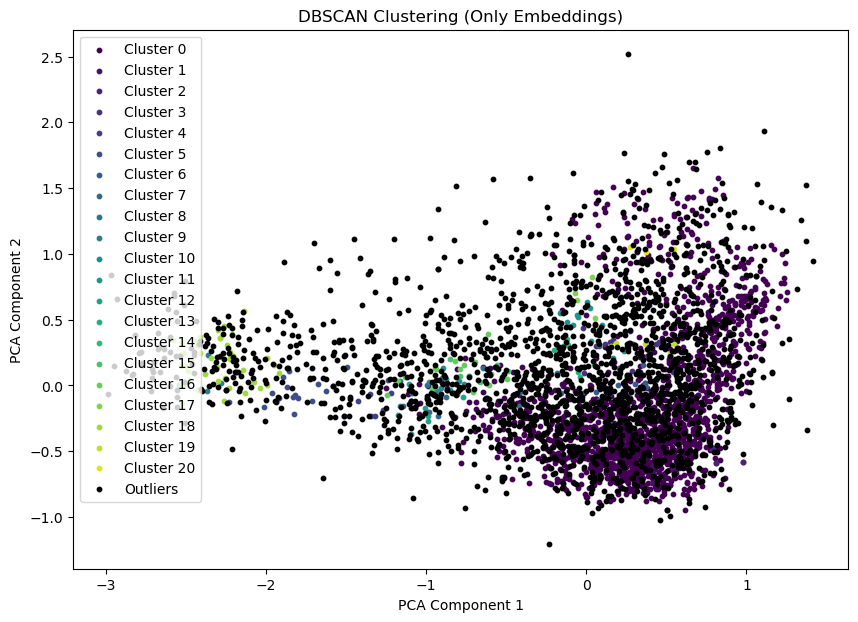

In [65]:
plot_dbscan_clusters(df, 'dbscan_labels_embeddings', 'DBSCAN Clustering (Only Embeddings)')


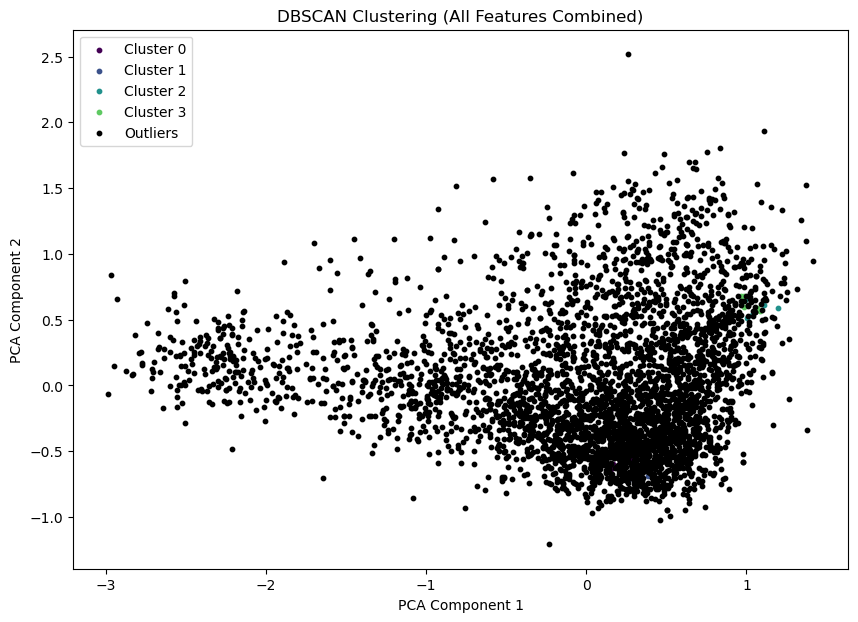

In [66]:
plot_dbscan_clusters(df, 'dbscan_labels_all_features', 'DBSCAN Clustering (All Features Combined)')


# AFTER RUNNIGN BOTH

In [68]:
# Encoding stance labels as numbers (if they are strings)
stance_mapping = {"PRO": 1, "ANTI": -1, "NEU": 0}
df['stance_tfidf'] = df['stance_tfidf'].replace(stance_mapping)


C:\Users\jaysh\AppData\Local\Temp\ipykernel_5304\551245114.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['stance_tfidf'] = df['stance_tfidf'].replace(stance_mapping)


In [69]:
# Define the most relevant features for Bias detection
bias_features = [
    'sentiment_score',                # Sentiment score (extreme values indicate bias)
    'pro_immigration_tfidf',          # Stance Analysis (Pro-Immigration)
    'anti_immigration_tfidf',         # Stance Analysis (Anti-Immigration)
    'stance_tfidf'                    # General Stance Score (Pro vs. Anti)
]

# Combine embeddings with selected bias-related features
from sklearn.preprocessing import MinMaxScaler

# Scale the additional bias-related features
df_bias_features = df[bias_features]
df_bias_scaled = MinMaxScaler().fit_transform(df_bias_features)

# Combine the scaled bias features with embeddings
X_bias_combined = np.hstack([X_embeddings_scaled, df_bias_scaled])


In [70]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# K-Means with 2 clusters (Bias vs. Not Bias)
kmeans_bias = KMeans(n_clusters=2, random_state=42)
kmeans_bias.fit(X_bias_combined)

# Save labels and evaluate
df['kmeans_labels_bias'] = kmeans_bias.labels_
silhouette_bias = silhouette_score(X_bias_combined, kmeans_bias.labels_)

print(f"K-Means (Bias Detection) - Silhouette Score: {silhouette_bias}")


K-Means (Bias Detection) - Silhouette Score: 0.29074558802123435


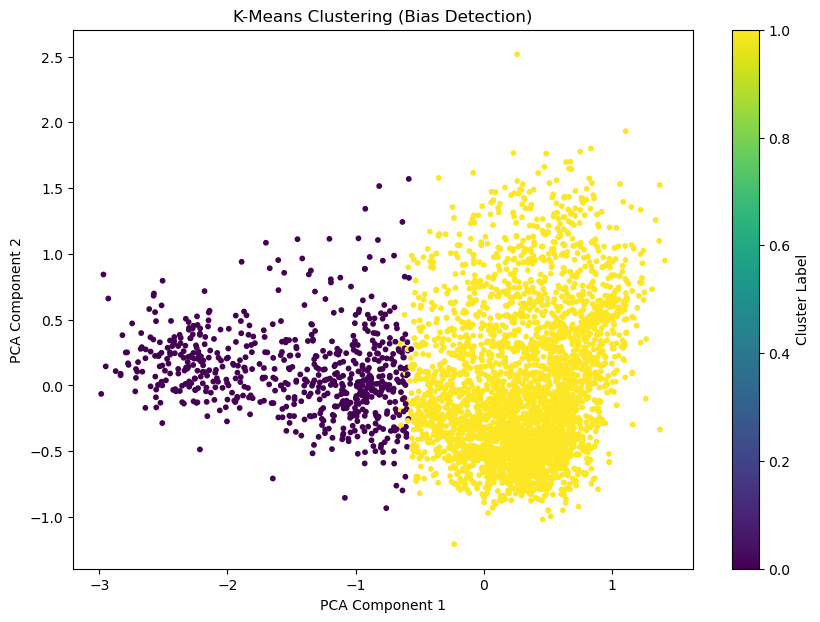

kmeans_labels_bias
1    3176
0     656
Name: count, dtype: int64
                    sentiment_score  pro_immigration_tfidf  \
kmeans_labels_bias                                           
0                         -0.007082               0.542637   
1                          0.048958               1.353530   

                    anti_immigration_tfidf  
kmeans_labels_bias                          
0                                 0.820624  
1                                 1.270609  


In [71]:
plot_clusters(df, 'kmeans_labels_bias', 'K-Means Clustering (Bias Detection)')
print(df['kmeans_labels_bias'].value_counts())
print(df.groupby('kmeans_labels_bias')[['sentiment_score', 'pro_immigration_tfidf', 'anti_immigration_tfidf']].mean())


In [72]:
print(df['kmeans_labels_bias'].value_counts())


kmeans_labels_bias
1    3176
0     656
Name: count, dtype: int64


In [73]:
print(df.groupby('kmeans_labels_bias')[['sentiment_score', 'pro_immigration_tfidf', 'anti_immigration_tfidf']].mean())


                    sentiment_score  pro_immigration_tfidf  \
kmeans_labels_bias                                           
0                         -0.007082               0.542637   
1                          0.048958               1.353530   

                    anti_immigration_tfidf  
kmeans_labels_bias                          
0                                 0.820624  
1                                 1.270609  


In [74]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

# Select relevant features
bias_features = ['sentiment_score', 'pro_immigration_tfidf', 'anti_immigration_tfidf']
df_bias_features = df[bias_features]

# Scale features
df_bias_scaled = MinMaxScaler().fit_transform(df_bias_features)

# Apply K-Means
kmeans_bias_only = KMeans(n_clusters=2, random_state=42)
kmeans_bias_only.fit(df_bias_scaled)

# Save labels and evaluate
df['kmeans_labels_bias_only'] = kmeans_bias_only.labels_
silhouette_bias_only = silhouette_score(df_bias_scaled, kmeans_bias_only.labels_)
print(f"K-Means (Bias Features Only) - Silhouette Score: {silhouette_bias_only}")


K-Means (Bias Features Only) - Silhouette Score: 0.38231818211306107


# Gaussian Mixture Models

In [75]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# Apply GMM
gmm = GaussianMixture(n_components=2, random_state=42)
gmm_labels = gmm.fit_predict(X_bias_combined)

# Save labels and calculate Silhouette Score
df['gmm_labels'] = gmm_labels
silhouette_gmm = silhouette_score(X_bias_combined, gmm_labels)

print(f"Gaussian Mixture Model - Silhouette Score: {silhouette_gmm}")


Gaussian Mixture Model - Silhouette Score: 0.1441582838484415


# HDBSCAN

In [77]:
import hdbscan

# Apply HDBSCAN
hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=20, min_samples=5)
hdbscan_labels = hdbscan_model.fit_predict(X_bias_combined)

# Save labels (note: -1 is noise in HDBSCAN)
df['hdbscan_labels'] = hdbscan_labels

# Calculate silhouette score for non-outlier points only
valid_labels = hdbscan_labels[hdbscan_labels != -1]
if len(valid_labels) > 1:
    silhouette_hdbscan = silhouette_score(X_bias_combined[hdbscan_labels != -1], valid_labels)
else:
    silhouette_hdbscan = None  # Not enough clusters to calculate Silhouette Score

print(f"HDBSCAN - Silhouette Score: {silhouette_hdbscan}")


c:\Users\jaysh\anaconda3\envs\tfg_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\jaysh\anaconda3\envs\tfg_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


HDBSCAN - Silhouette Score: 0.06938378548132597


Spectral

In [78]:
from sklearn.cluster import SpectralClustering

# Apply Spectral Clustering
spectral_model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors', random_state=42)
spectral_labels = spectral_model.fit_predict(X_bias_combined)

# Save labels and calculate Silhouette Score
df['spectral_labels'] = spectral_labels
silhouette_spectral = silhouette_score(X_bias_combined, spectral_labels)

print(f"Spectral Clustering - Silhouette Score: {silhouette_spectral}")


Spectral Clustering - Silhouette Score: 0.12773310700670082


Agglomerative

In [79]:
from sklearn.cluster import AgglomerativeClustering

# Apply Agglomerative Clustering
agg_model = AgglomerativeClustering(n_clusters=2)
agg_labels = agg_model.fit_predict(X_bias_combined)

# Save labels and calculate Silhouette Score
df['agg_labels'] = agg_labels
silhouette_agg = silhouette_score(X_bias_combined, agg_labels)

print(f"Agglomerative Clustering - Silhouette Score: {silhouette_agg}")


Agglomerative Clustering - Silhouette Score: 0.29301858767920624
